In [36]:
import numpy as np
import ContinuousSignal as cs
import matplotlib.pyplot as plt
import os

In [37]:
class LtiContinuous:
    """Initializes the system with the system impulse response"""
    def __init__(self, impulse_response=None,INF=5):
        self.impulse_response = impulse_response
        self.INF = INF
        
    """Decomposes the input_signal and returns the unit impulse and their coefficients"""
    def linear_combination_of_impulses(self, input_signal , delta):
        impulses = []
        
        """size of the impulses would be (-INF,0,INF)"""
        tau = np.arange(-self.INF*delta ,(self.INF+1) * delta,delta)
        tau = np.round(tau,decimals=10)
        x_t = input_signal.func(tau)
        coefficient = x_t * delta
        # coefficient = coefficient[:-1]
        
        n = len(tau)
        for i in range(n-1):
            # print(f"tau value {tau[i]} and {tau[i+1]}")
            def make_impulse(start, end):
                return lambda t: np.where((t >= start) & (t < end), 1/delta, 0)
            impulse = cs.ContinuousSignal(make_impulse(tau[i], tau[i+1]),tau[i])
            impulses.append(impulse)
            
        return impulses,coefficient
            
    
    
    """Finds the output of a signal inserted in a Linear Time Invariance system"""
    def output_approx(self, input_signal ,delta):
        output_signal = cs.ContinuousSignal(lambda t: 0*t)
        impulses , coefficients = self.linear_combination_of_impulses(input_signal, delta)
        impulse_responses = []
        
        for i,c in zip(impulses,coefficients):
            shifted_impulse_response = self.impulse_response.shift(i.start)
            shifted_impulse_response.set_start(i.start)
            impulse_responses.append(shifted_impulse_response)
            scaled_response = shifted_impulse_response.multiply_const_factor(c)
            output_signal = output_signal.add(scaled_response)
        
        return output_signal,impulse_responses,coefficients
        
        

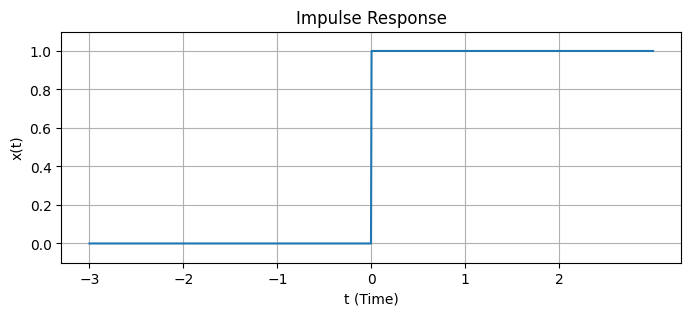

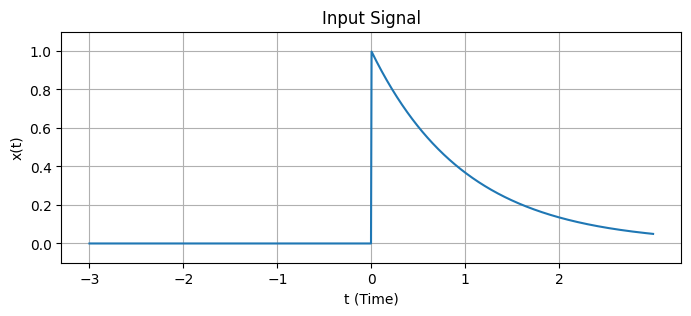

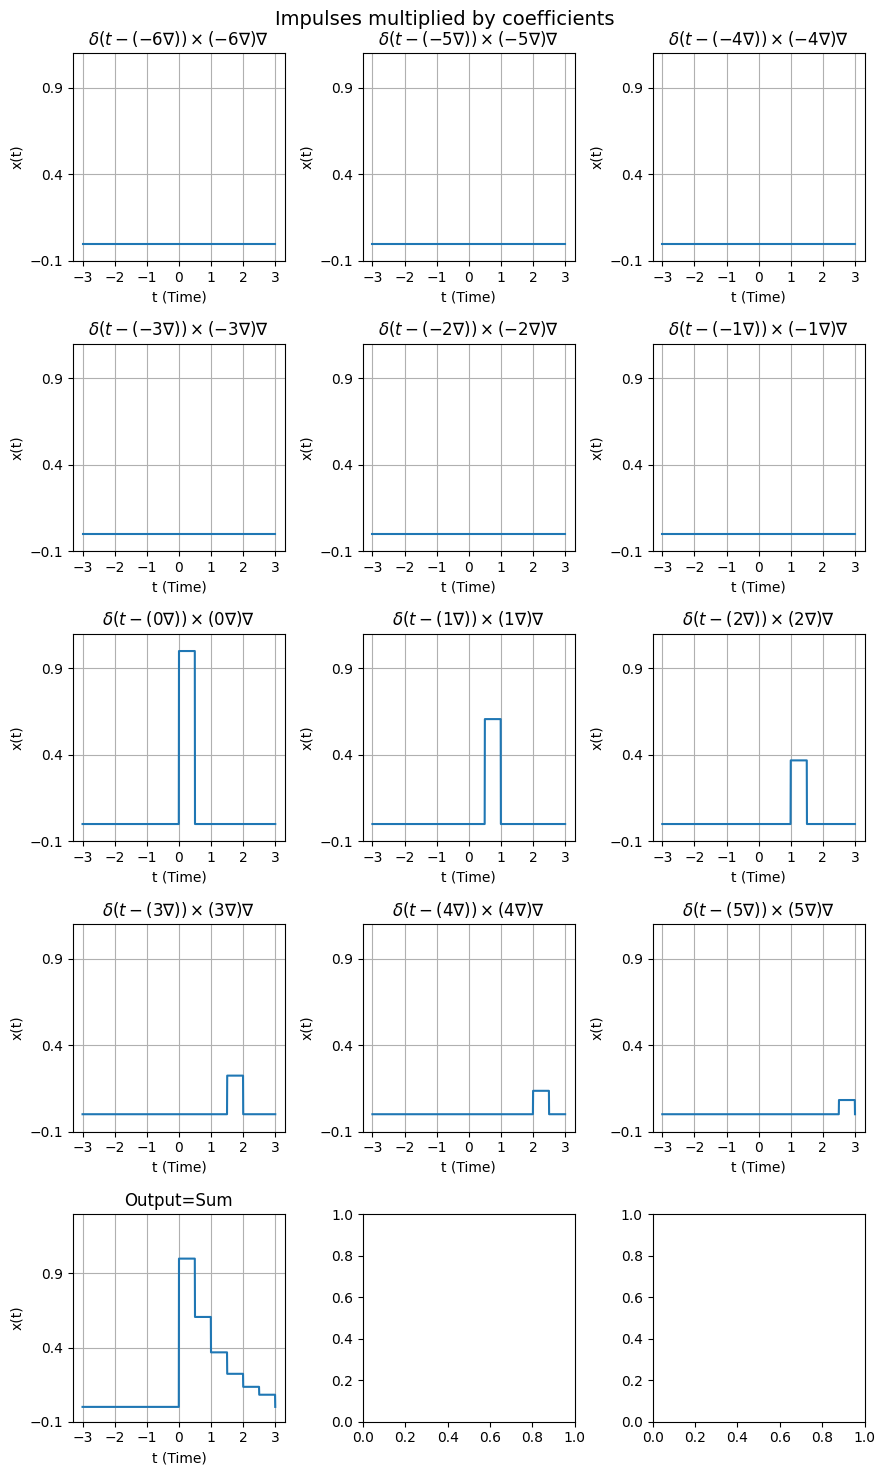

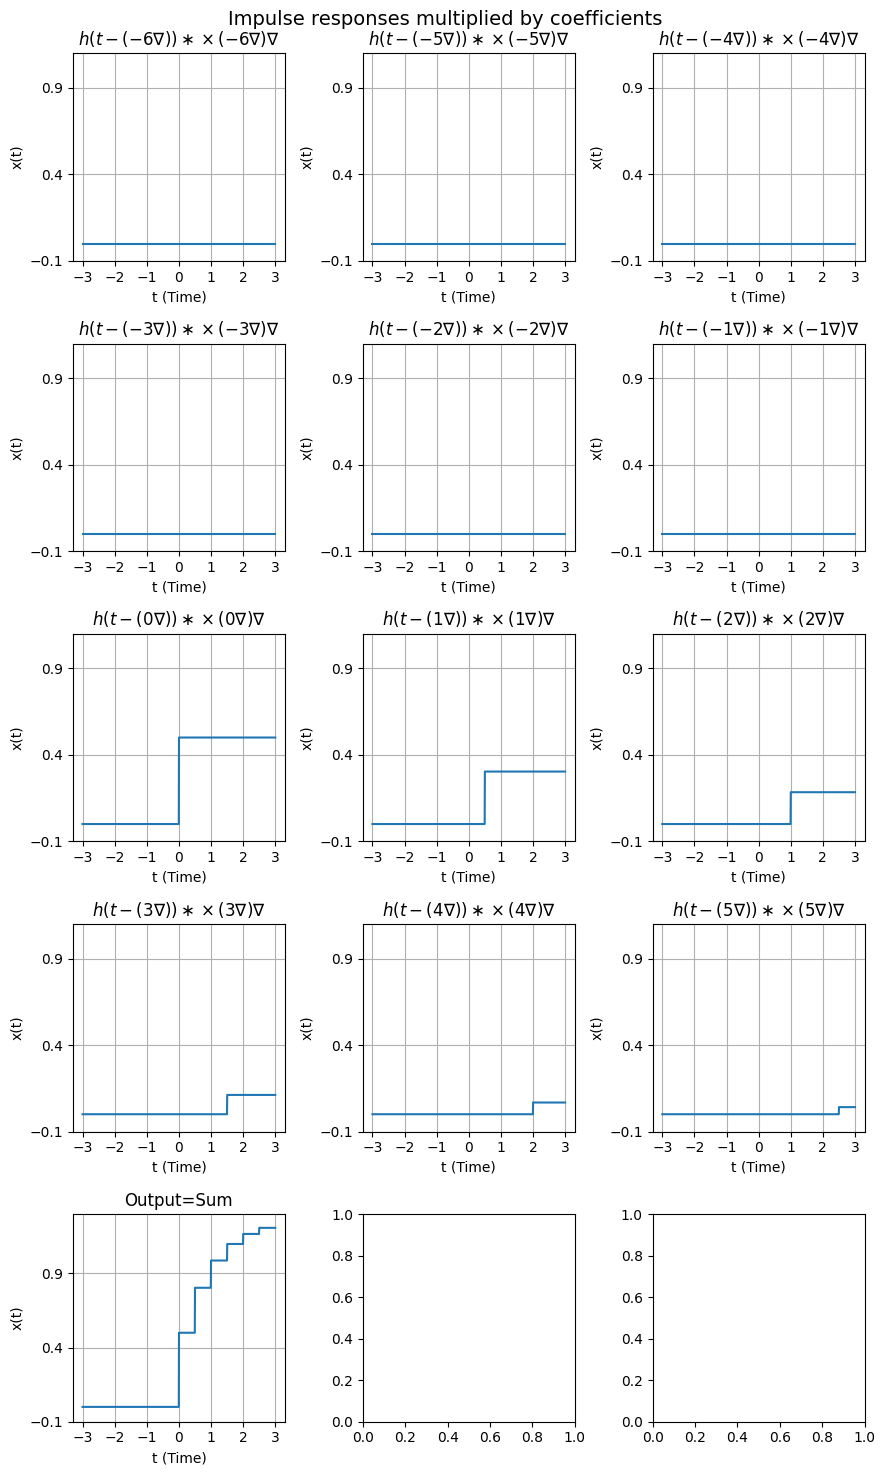

In [39]:
def plot_impulse(unit_impulses,reconstructed_signal,which_impulse="input impulse",suptitle="",delta=.5,plot_name="plots"):
    num_impulses = len(unit_impulses)
    rows = (num_impulses + 3) // 3  # Calculate number of rows needed
    cols = 3  # Number of columns
    
    fig, axs = plt.subplots(rows, cols , figsize=(cols*3, rows*3))
    axs = axs.flatten()
    size_of_subplots = len(axs)
    size_of_impulses = len(unit_impulses)
    
    # Plot the individual impulse responses
    for i, impulse in enumerate(unit_impulses):
        # Inside the plot_impulse function
        if which_impulse == "input impulse":
            title = fr'$\delta(t - ({round((impulse.start)/delta)}\nabla)) \times({round((impulse.start)/delta)}\nabla)\nabla$'
        else:
            title = fr'$h(t - ({round((impulse.start)/delta)}\nabla)) \ast \times({round((impulse.start)/delta)}\nabla)\nabla$'
    
        impulse.plot_ax(ax=axs[i], title=title, y_range=(-.1,1.1))
        
    # Plot the sum of the impulse responses
    reconstructed_signal.plot_ax(ax=axs[-(size_of_subplots-size_of_impulses)], title="Output=Sum",y_range=(-.1,1.3))
    
    # Add overall title
    fig.suptitle(suptitle, fontsize=14)
    plt.subplots_adjust(top=.9)
    
    plt.tight_layout()
    
    plt.show()
    # # Get the current working directory
    # current_dir = os.getcwd()
    # 
    # # Create the 'plot' directory in the current working directory
    # plot_dir = os.path.join(current_dir, "Continuous_Plots")
    # os.makedirs(plot_dir, exist_ok=True)
    # 
    # # Save the figure in the ./plot directory
    # fig_path = os.path.join(plot_dir, f"{plot_name}.png")
    # plt.savefig(fig_path)
    # print(f"Figure saved as: {fig_path}")
    # # 
    # # Close the plot to free up memory
    # plt.close()

def show_linear(lti_system,input_signal,delta):
    
    impulses,coefficients = lti_system.linear_combination_of_impulses(input_signal,delta)
    
    unit_impulses = []
    reconstructed_signal = cs.ContinuousSignal(lambda t: 0*t)
    
    for shifted_unit_impulse,coefficient in zip(impulses,coefficients):
        scaled_impulse = shifted_unit_impulse.multiply_const_factor(coefficient)
        scaled_impulse.set_start(shifted_unit_impulse.start)
        unit_impulses.append(scaled_impulse)
        reconstructed_signal = reconstructed_signal.add(scaled_impulse)
        
    plot_impulse(unit_impulses,reconstructed_signal,which_impulse="input impulse",suptitle="Impulses multiplied by coefficients",delta=delta,plot_name="input impulses")

def show_output_approx(lti_system,input_signal,delta):
    output,shifted_impulse_responses,coefficients = lti_system.output_approx(input_signal,delta)
    
    impulse_responses = []
    for shifted_impulse_response,coefficient in zip(shifted_impulse_responses,coefficients):
        scaled_impulse_response = shifted_impulse_response.multiply_const_factor(coefficient)
        scaled_impulse_response.set_start(shifted_impulse_response.start)
        # print(shifted_impulse_response.start)
        # shifted_impulse_response.plot(title="Shifted Impulse Response")
        impulse_responses.append(scaled_impulse_response)
        
    plot_impulse(impulse_responses,output,which_impulse="output impulse",suptitle="Impulse responses multiplied by coefficients",delta=delta,plot_name="output_impulses")
    

def main():
    # Define the impulse response 
    impulse_response = cs.ContinuousSignal(func=(lambda t: np.where(t>=0,1,0)))
    impulse_response.plot(title="Impulse Response",t_range=(-3,3),y_range=(-.1,1.1))
    # Define the input signal
    input_signal = cs.ContinuousSignal(func=(lambda t: np.exp(-t) * (t >= 0)))
    input_signal.plot(title="Input Signal",t_range=(-3,3),y_range=(-.1,1.1))
    
    # Create LTI system
    lti_system = LtiContinuous(impulse_response, INF=6)
    
    # show the unit_impulse multiplied by their coefficients and reconstructed signal
    show_linear(lti_system,input_signal,.5)
    # show the Impulse response multiplied by their coefficients and output signal
    show_output_approx(lti_system,input_signal,.5)
   
    
if __name__ == "__main__":
    main()



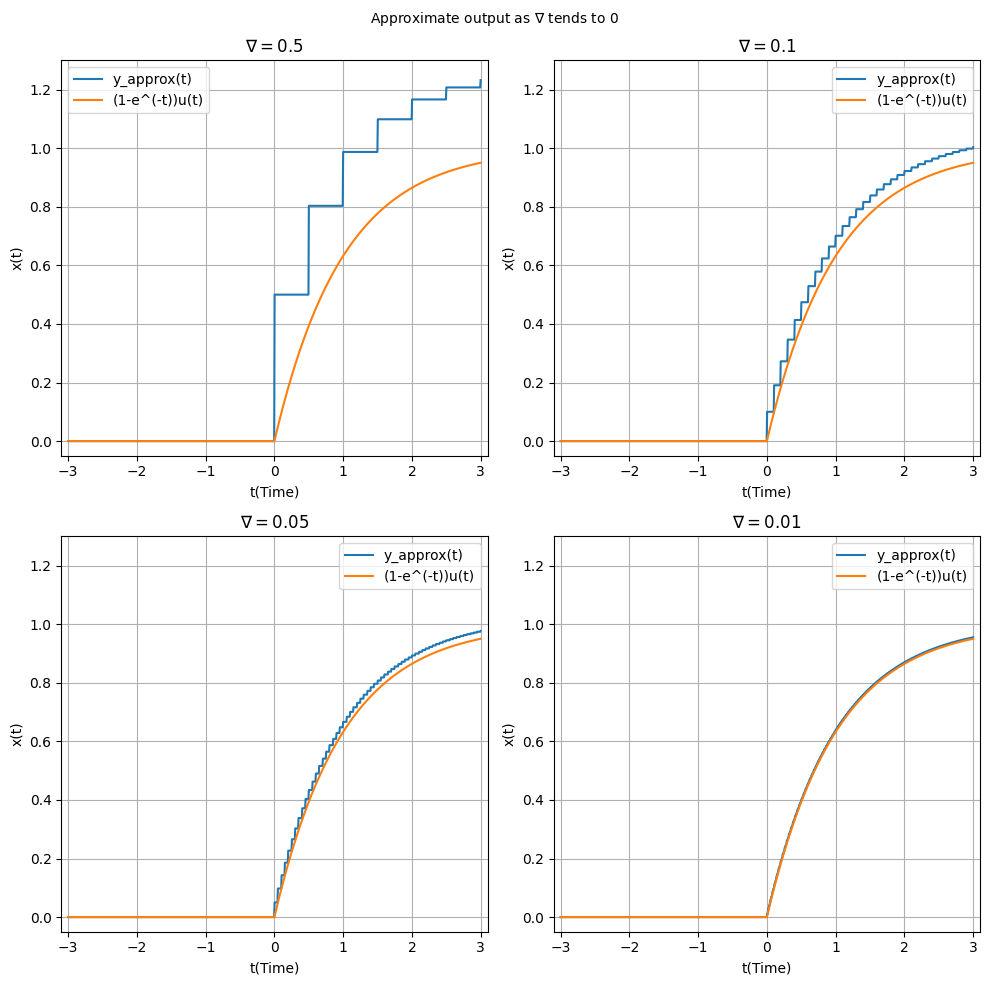

In [40]:
# Reconstruction of input signal with varying delta

#The impulse response and input signal
impulse_response = cs.ContinuousSignal(func=(lambda t: np.where(t>=0,1,0)))
input_signal = cs.ContinuousSignal(func=(lambda t: np.exp(-t) * (t >= 0)))

# Create LTI system
lti_system = LtiContinuous(impulse_response, INF=1000)

# Create a 2x2 subplot
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
fig.suptitle(r'Approximate output as $\nabla$ tends to 0', fontsize=10)

# delta values
delta_values = [0.5, 0.1, 0.05, 0.01]

# Time range for plotting
t_range = np.linspace(-3, 3, 1000)

# The reference function calulated by hand (1-e^(-t))u(t))
reference_func = lambda t: (1 - np.exp(-t))*(np.where(t>=0,1,0))

# Plot for each delta value
for i, delta in enumerate(delta_values):
    row = i // 2
    col = i % 2
    
    # Get output signal
    out, _, _ = lti_system.output_approx(input_signal, delta)
    
    # Plot output signal and reference function
    axs[row, col].plot(t_range, out.func(t_range), label='y_approx(t)')
    axs[row, col].plot(t_range, reference_func(t_range), label='(1-e^(-t))u(t)')
    
    axs[row, col].set_title(fr'$\nabla = {delta}$')
    axs[row, col].set_ylim(-.05, 1.3)
    axs[row, col].set_xlim(-3.1, 3.1)
    axs[row, col].legend()
    axs[row, col].grid(True)
    axs[row, col].set_xlabel('t(Time)')
    axs[row, col].set_ylabel('x(t)')

# Adjust layout
plt.tight_layout()
plt.show()

# # Get the current working directory
# current_dir = os.getcwd()
# 
# # Create the 'plot' directory in the current working directory
# plot_dir = os.path.join(current_dir, "plot")
# os.makedirs(plot_dir, exist_ok=True)
# 
# # Save the figure in the ./plot directory
# fig_path = os.path.join(plot_dir, "delta_comparison_output_plots.png")
# plt.savefig(fig_path)
# print(f"Figure saved as: {fig_path}")
# # 
# # Close the plot to free up memory
# plt.close()

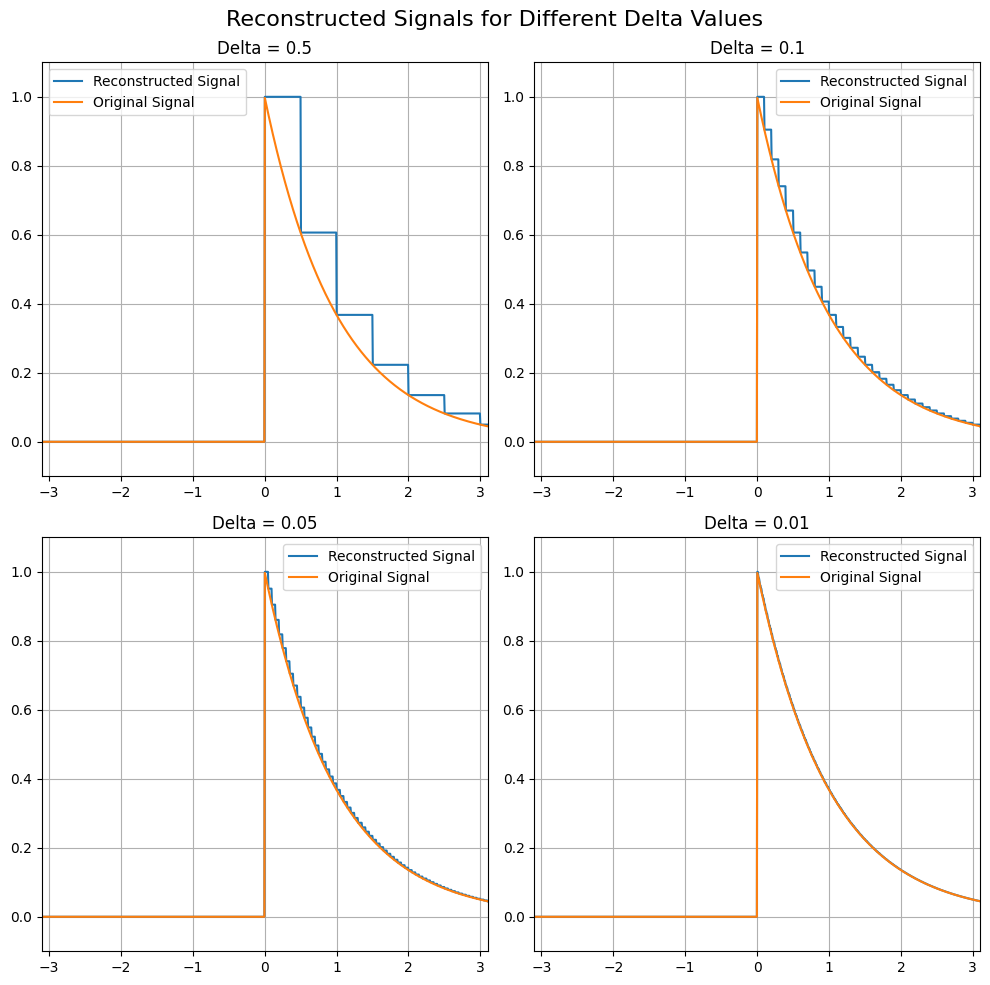

In [41]:

lti_system = LtiContinuous(INF=1000)

input_signal = cs.ContinuousSignal(lambda t: np.exp(-t) * (t >= 0))

# Create a 2x2 subplot
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
fig.suptitle("Reconstructed Signals for Different Delta Values", fontsize=16)

# Define delta values
delta_values = [0.5, 0.1, 0.05, 0.01]

# Time range for plotting
t_range = np.linspace(-3.1, 3.1, 1000)

# Plot for each delta value
for i, delta in enumerate(delta_values):
    row = i // 2
    col = i % 2
    
    # Get impulses and coefficients
    imp, co = lti_system.linear_combination_of_impulses(input_signal, delta)
    
    # Reconstruct the signal
    reconstructed_signal = cs.ContinuousSignal(lambda t: 0*t)
    for impulse, coeff in zip(imp, co):
        new_impulse = impulse.multiply_const_factor(coeff)
        reconstructed_signal = reconstructed_signal.add(new_impulse)
    
    # Plot original and reconstructed signals
    axs[row, col].plot(t_range, reconstructed_signal.func(t_range), label='Reconstructed Signal')
    axs[row, col].plot(t_range, input_signal.func(t_range), label='Original Signal')
    
    axs[row, col].set_title(f'Delta = {delta}')
    axs[row, col].set_ylim(-0.1, 1.1)
    axs[row, col].set_xlim(-3.1, 3.1)
    axs[row, col].legend()
    axs[row, col].grid(True)

# Adjust layout
plt.tight_layout()
plt.show()

# # Get the current working directory
# current_dir = os.getcwd()
# 
# # Create the 'plot' directory in the current working directory
# plot_dir = os.path.join(current_dir, "plot")
# os.makedirs(plot_dir, exist_ok=True)
# 
# # Save the figure in the ./plot directory
# fig_path = os.path.join(plot_dir, "delta_comparison_input_plots.png")
# plt.savefig(fig_path)
# print(f"Figure saved as: {fig_path}")
# # 
# # Close the plot to free up memory
# plt.close()